<a href="https://colab.research.google.com/github/kkzkwtr/GCI_2025_summer_competition01/blob/main/GCI_comptition01_v20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

import warnings
warnings.filterwarnings('ignore')

In [3]:
path = "/content/drive/My Drive/Colab Notebooks/GCI_2025_summer/Competitions/competition_1/"

df = pd.read_csv(path + 'data/train.csv')
df_test = pd.read_csv(path + 'data/test.csv')

#全結合データ
df_concat = pd.concat([df,df_test],ignore_index=True)

###欠損値補完
AgeはPclass, Sex, Parch, SibSp, Title(onehot)を説明変数としたランダムフォレストで補完する

手順
1. Nameから敬称(Title)を抽出し、Mr,Mrs,Miss,Master,Otherに分ける。
2.Titleをone-hotエンコーディング
3.ランダムフォレスト適応

###Embarked & Fareの欠損値補完
カウント数が多いSで補完

Fare: EmbarkedとPclassのメジアンで補完


In [4]:
df_concat['Embarked'].fillna('S',inplace=True)
embarked = df_concat['Embarked']
embarked_ohe = pd.get_dummies(embarked,prefix='Embarked')
df_concat = pd.concat([df_concat, embarked_ohe], axis=1)
fare = df_concat[(df_concat['Embarked'] == 'S') & (df_concat['Pclass'] == 3)]['Fare'].median()
df_concat['Fare'].fillna(fare,inplace=True)
df_concat.drop(['Embarked'], axis=1, inplace=True)
df_concat.isnull().sum()

,0
PassengerId,0
Perished,418
Pclass,0
Name,0
Sex,0
Age,263
SibSp,0
Parch,0
Ticket,0
Fare,0


In [5]:
df_concat['Title'] = df_concat['Name'].map(lambda x: x.split(',')[1].split('.')[0].strip())
df_concat['Title'].value_counts()
# df_concat['Name_length'] = df_concat['Name'].map(lambda x: len(x))
# 例: pandas DataFrame f_concat に "Title" カラムがあるとする
mapping = {
    # 成人男性
    'Mr':       'Mr',

    # 未婚女性
    'Miss':     'Miss',
    'Mlle':     'Miss',   # Mlle はフランス語で Miss に相当
    'Ms':       'Miss',   # Ms は未婚/既婚を区別しないが、ここでは Miss とみなす

    # 既婚女性
    'Mrs':      'Mrs',
    'Mme':      'Mrs',    # Mme はフランス語で Mrs に相当

    # 子供（男児）
    'Master':   'Master',

    # 貴族
    'Sir':          'Royalty',
    'Don':          'Royalty',
    'Jonkheer':     'Royalty',
    'Lady':         'Royalty',
    'the Countess': 'Royalty',
    'Dona':         'Royalty',

    # 軍人・医師・聖職者
    'Dr':       'Officer',
    'Rev':      'Officer',
    'Major':    'Officer',
    'Col':      'Officer',
    'Capt':     'Officer'
}
df_concat['Title'] = df_concat['Title'].map(mapping)
# df_concat['Title'].fillna('Rare', inplace=True)

Title = df_concat['Title']
Title_ohe = pd.get_dummies(Title,prefix='Title')
df_concat = pd.concat([df_concat, Title_ohe], axis=1)

# Age
# Name_length
df_concat['Name_length'] = df_concat['Name'].apply(lambda x: len(x.strip()))


from sklearn.ensemble import RandomForestRegressor
#AgeをPclass, Sex, Parch, SibSpでランダムフォレストで推定

# 参照: https://qiita.com/jun40vn/items/d8a1f71fae680589e05c

#説明変数
age_df_concat = df_concat[["Age", "Pclass", "Sex", "Parch", "SibSp","Title_Master","Title_Miss","Title_Mr","Title_Mrs","Title_Royalty", "Title_Officer","Embarked_S","Embarked_Q","Embarked_C"]]

age_df_concat.replace({'Sex': {'male': 0, 'female': 1}}, inplace=True)

#学習データ->欠損してないデータ、テストデータ->欠損データ
known_age = age_df_concat[age_df_concat.Age.notnull()].values
unknown_age = age_df_concat[age_df_concat.Age.isnull()].values

X = known_age[:, 1:]
y = known_age[:, 0]

# ランダムフォレスト年齢推定モデル
rf_age = RandomForestRegressor(n_estimators=300,random_state=42, n_jobs=-1)
rf_age.fit(X, y)

predictedAges = rf_age.predict(unknown_age[:, 1:])
df_concat.loc[ (df_concat.Age.isnull()), 'Age' ] = predictedAges
df_concat.isnull().sum()

,0
PassengerId,0
Perished,418
Pclass,0
Name,0
Sex,0
Age,0
SibSp,0
Parch,0
Ticket,0
Fare,0


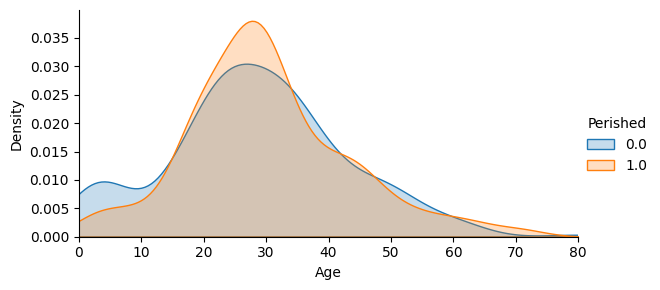

In [ ]:
facet = sns.FacetGrid(df_concat[:891], hue='Perished',aspect=2)
facet.map(sns.kdeplot, 'Age', shade=True)
facet.set(xlim=(0, df_concat[:891]['Age'].max()))
facet.add_legend()
plt.show()

###Cabinの欠損値補完
Cabinの頭文字を取得して、欠損データには'U'(Unknown)とする。
ばらつきがあるので、頻度エンコーディング
Cabin_label
U    1014
C      94
B      65
D      46
E      41
A      22
F      21
G       5
T       1

In [6]:
#Cabinの欠損値
df_concat['Cabin'] = df_concat['Cabin'].fillna('Unknown')
df_concat['Cabin_label'] = df_concat['Cabin'].str.get(0)
# mean_perished = df_concat.groupby('Cabin_label')['Perished'].mean()
# order = mean_perished.sort_values(ascending=True).index.tolist()
# sns.barplot(x='Cabin_label', y='Perished', data=df_concat,order=order, palette='Set3')
# plt.show()

# freq = df_concat.loc[:890,'Cabin_label'].value_counts(normalize=True).to_dict()
# df_concat['Cabin_label'] = df_concat['Cabin_label'].map(freq)
# df_concat['Cabin_label'].fillna(0, inplace=True)
Cabin_label = df_concat['Cabin_label']
Cabin_label_ohe = pd.get_dummies(Cabin_label,prefix='Cabin')
df_concat = pd.concat([df_concat, Cabin_label_ohe], axis=1)
df_concat.drop(['Cabin_label'], axis=1, inplace=True)
df_concat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 31 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    1309 non-null   int64  
 1   Perished       891 non-null    float64
 2   Pclass         1309 non-null   int64  
 3   Name           1309 non-null   object 
 4   Sex            1309 non-null   object 
 5   Age            1309 non-null   float64
 6   SibSp          1309 non-null   int64  
 7   Parch          1309 non-null   int64  
 8   Ticket         1309 non-null   object 
 9   Fare           1309 non-null   float64
 10  Cabin          1309 non-null   object 
 11  Embarked_C     1309 non-null   bool   
 12  Embarked_Q     1309 non-null   bool   
 13  Embarked_S     1309 non-null   bool   
 14  Title          1309 non-null   object 
 15  Title_Master   1309 non-null   bool   
 16  Title_Miss     1309 non-null   bool   
 17  Title_Mr       1309 non-null   bool   
 18  Title_Mr

###特徴量エンジニアリング
Ticketをグループ化

Family -> SibSp + Parch +1 ->グループ化

IsAlone ->一人かどうかでグループ化

In [7]:
#Ticket統計
Ticket_counts = dict(df_concat['Ticket'].value_counts())
df_concat['TicketGroup'] = df_concat['Ticket'].map(Ticket_counts)
# sns.barplot(x='TicketGroup', y='Perished', data=df_concat, palette='Set3')
df_concat.loc[(df_concat['TicketGroup'] >= 2) & (df_concat['TicketGroup'] <= 4), 'Ticket_label'] = 2
df_concat.loc[(df_concat['TicketGroup'] >= 5) & (df_concat['TicketGroup'] <= 8) | (df_concat['TicketGroup']==1), 'Ticket_label'] = 1
df_concat.loc[(df_concat['TicketGroup'] >=11), 'Ticket_label'] = 0

# Ticketの先頭文字列をカテゴリ化
df_concat['Ticket_Prefix'] = df_concat['Ticket'].apply(lambda x: x.split()[0] if not x.isdigit() else 'NUM')
ticket_counts = df_concat['Ticket_Prefix'].value_counts()
common_prefixes = ticket_counts[ticket_counts > 15].index  # 出現数以上などで閾値設定

df_concat['Ticket_Prefix_Grouped'] = df_concat['Ticket_Prefix'].apply(
    lambda x: x if x in common_prefixes else 'Rare'
)
print(df_concat['Ticket_Prefix_Grouped'].value_counts())

# One-hot
Ticket_Prefix_Grouped = df_concat['Ticket_Prefix_Grouped']
Ticket_Prefix_Grouped_ohe = pd.get_dummies(Ticket_Prefix_Grouped,prefix='Ticket_Prefix')
df_concat = pd.concat([df_concat, Ticket_Prefix_Grouped_ohe], axis=1)


#Family変数の追加 + グルーピング
#https://qiita.com/jun40vn/items/d8a1f71fae680589e05c
df_concat['Family'] = df_concat['SibSp'] + df_concat['Parch'] + 1
df_concat.loc[(df_concat['Family'] >= 2) & (df_concat['Family'] <= 4), 'Family_label'] = 2
df_concat.loc[(df_concat['Family'] >= 5) & (df_concat['Family'] <= 7) | (df_concat['Family']==1), 'Family_label'] = 1
df_concat.loc[(df_concat['Family'] >= 8), 'Family_label'] = 0

#一人かそれ以外かでグループ化
df_concat['IsAlone'] = (df_concat['Family'] == 1).astype(int)
# df_concat['IsAlone'] = (df_concat['Family'] == 1).astype(int)
df_concat.drop(['Family','SibSp','Parch'], axis=1, inplace=True)
df_concat.info()

Ticket_Prefix_Grouped
NUM           957
Rare          198
PC             92
C.A.           46
SOTON/O.Q.     16
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 40 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   PassengerId               1309 non-null   int64  
 1   Perished                  891 non-null    float64
 2   Pclass                    1309 non-null   int64  
 3   Name                      1309 non-null   object 
 4   Sex                       1309 non-null   object 
 5   Age                       1309 non-null   float64
 6   Ticket                    1309 non-null   object 
 7   Fare                      1309 non-null   float64
 8   Cabin                     1309 non-null   object 
 9   Embarked_C                1309 non-null   bool   
 10  Embarked_Q                1309 non-null   bool   
 11  Embarked_S                1309 non-

###Fareのスケーリング

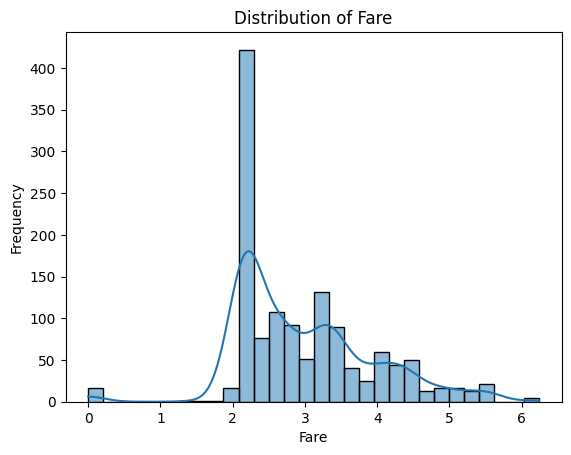

In [8]:
# prompt: Fareの分布を見たい
df_concat['Fare_log'] = np.log1p(df_concat['Fare'])


import matplotlib.pyplot as plt
sns.histplot(df_concat['Fare_log'], bins=30, kde=True)
plt.title('Distribution of Fare')
plt.xlabel('Fare')
plt.ylabel('Frequency')
plt.show()

# Fareのビニング
# df_concat['Fare_bin'] = pd.qcut(df_concat['Fare'], bins=4,labels=False)

###Ageビニング

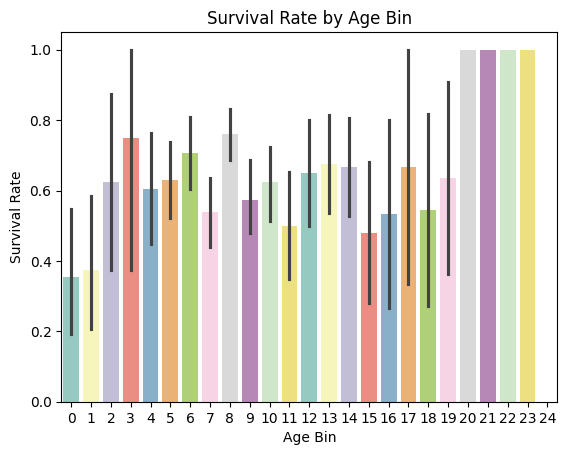

In [44]:
# prompt: AgeとPerishedをビニングで可視化

import pandas as pd
import matplotlib.pyplot as plt
# Ageのビニング
df_concat['Age_bin'] = pd.cut(df_concat['Age'], bins=25,labels=False)

# Age_binとPerishedの関係を可視化
sns.barplot(x='Age_bin', y='Perished', data=df_concat[:891], palette='Set3')
plt.title('Survival Rate by Age Bin')
plt.xlabel('Age Bin')
plt.ylabel('Survival Rate')
plt.show()

###エンコーディング

Sex ->onehot

Embarked -> onehot



In [9]:
# Sex
Sex = df_concat['Sex']
Sex_ohe = pd.get_dummies(Sex,prefix='Sex')

# Embarked
# Embarked = df_concat['Embarked']
# Embarked_ohe = pd.get_dummies(Embarked,prefix='Embarked')

df_concat = pd.concat([df_concat, Sex_ohe], axis=1)
df_concat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 43 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   PassengerId               1309 non-null   int64  
 1   Perished                  891 non-null    float64
 2   Pclass                    1309 non-null   int64  
 3   Name                      1309 non-null   object 
 4   Sex                       1309 non-null   object 
 5   Age                       1309 non-null   float64
 6   Ticket                    1309 non-null   object 
 7   Fare                      1309 non-null   float64
 8   Cabin                     1309 non-null   object 
 9   Embarked_C                1309 non-null   bool   
 10  Embarked_Q                1309 non-null   bool   
 11  Embarked_S                1309 non-null   bool   
 12  Title                     1309 non-null   object 
 13  Title_Master              1309 non-null   bool   
 14  Title_Mi

###相互作用特徴量

In [10]:
df_concat['Sex_male_Pclass'] = df_concat['Sex_male'] * df_concat['Pclass']
df_concat['Age_Pclass'] = df_concat['Age'] * df_concat['Pclass']
df_concat['Fare_log_Pclass'] = df_concat['Fare_log'] * df_concat['Pclass']
df_concat['Age_Fare_log'] = df_concat['Age'] * df_concat['Fare_log']
df_concat['Title_Mr_Pclass'] = df_concat['Title_Mr'] * df_concat['Pclass']
df_concat['IsAlone_Sex_male'] = df_concat['IsAlone'] * df_concat['Sex_male']

In [11]:
# Name, Sex, Cabin, Embarked, Titleドロップ
df_concat.drop(['Name', 'Sex', 'Cabin', 'Title'], axis=1, inplace=True)
df_concat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 45 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   PassengerId               1309 non-null   int64  
 1   Perished                  891 non-null    float64
 2   Pclass                    1309 non-null   int64  
 3   Age                       1309 non-null   float64
 4   Ticket                    1309 non-null   object 
 5   Fare                      1309 non-null   float64
 6   Embarked_C                1309 non-null   bool   
 7   Embarked_Q                1309 non-null   bool   
 8   Embarked_S                1309 non-null   bool   
 9   Title_Master              1309 non-null   bool   
 10  Title_Miss                1309 non-null   bool   
 11  Title_Mr                  1309 non-null   bool   
 12  Title_Mrs                 1309 non-null   bool   
 13  Title_Officer             1309 non-null   bool   
 14  Title_Ro

In [12]:
# 必要に応じて、カラムを削除
df_concat.drop(['Ticket','Fare'], axis=1, inplace=True)
df_concat.drop(['Ticket_Prefix','TicketGroup','Ticket_Prefix_Grouped',],axis=1,inplace=True)
df_concat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 40 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   PassengerId               1309 non-null   int64  
 1   Perished                  891 non-null    float64
 2   Pclass                    1309 non-null   int64  
 3   Age                       1309 non-null   float64
 4   Embarked_C                1309 non-null   bool   
 5   Embarked_Q                1309 non-null   bool   
 6   Embarked_S                1309 non-null   bool   
 7   Title_Master              1309 non-null   bool   
 8   Title_Miss                1309 non-null   bool   
 9   Title_Mr                  1309 non-null   bool   
 10  Title_Mrs                 1309 non-null   bool   
 11  Title_Officer             1309 non-null   bool   
 12  Title_Royalty             1309 non-null   bool   
 13  Name_length               1309 non-null   int64  
 14  Cabin_A 

In [45]:
df_concat.drop('Age', axis=1, inplace=True)

In [46]:
df = df_concat[:891]
df_test = df_concat[891:]
X = df.drop(['PassengerId', 'Perished'], axis=1).values
y = df['Perished'].values
X_test = df_test.drop(['PassengerId', 'Perished',], axis=1).values

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)
print(X.shape, y.shape)

(891, 38) (891,)


[LightGBM] [Info] Number of positive: 495, number of negative: 306
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000566 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 802
[LightGBM] [Info] Number of data points in the train set: 801, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.617978 -> initscore=0.480973
[LightGBM] [Info] Start training from score 0.480973
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

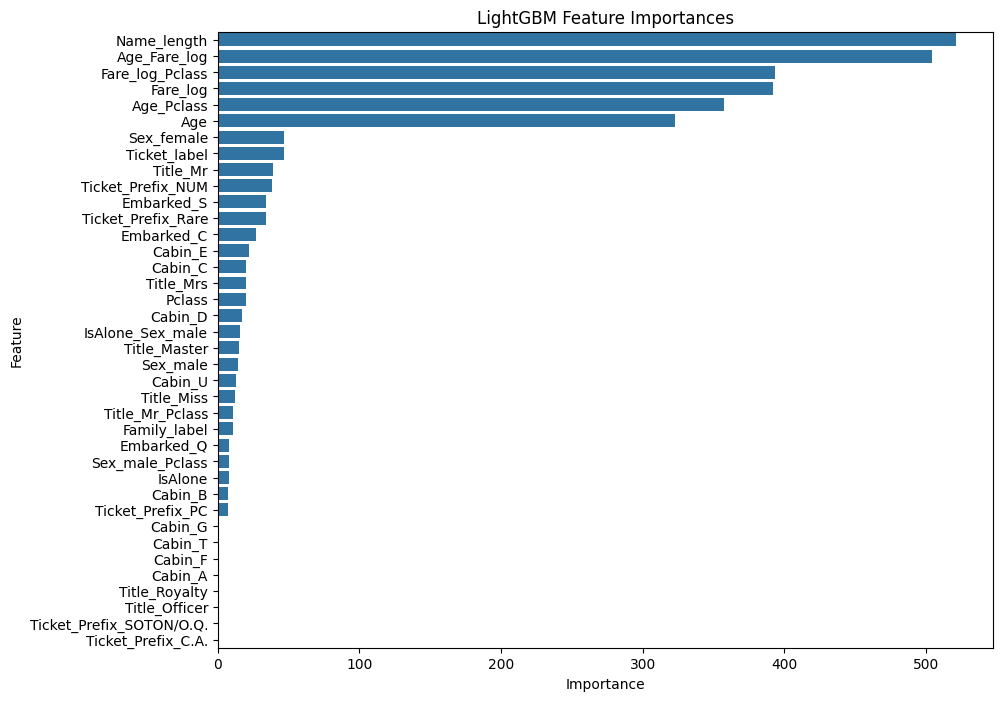

In [14]:
# prompt: lightGBMを使って、重要度を横棒グラフで算出

import pandas as pd
import matplotlib.pyplot as plt
!pip install lightgbm
import lightgbm as lgb
lgb_clf = lgb.LGBMClassifier(random_state=42)
lgb_clf.fit(X_train, y_train)
# 特徴量の重要度を取得
feature_importances = pd.DataFrame({
    'feature': df.drop(['PassengerId', 'Perished'], axis=1).columns,
    'importance': lgb_clf.feature_importances_
})
# 重要度で降順にソート
feature_importances = feature_importances.sort_values('importance', ascending=False)
# 横棒グラフで表示
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.title('LightGBM Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [15]:
rf_find = RandomForestClassifier(random_state=42, n_jobs=-1)
param_grid = {
    'n_estimators': [100, 300],
    'min_samples_split': [2, 3, 10],
    'min_samples_leaf': [3, 10]
}

grid_rf = GridSearchCV(rf_find, param_grid, cv=5, scoring='accuracy')
grid_rf.fit(X, y)

print("Best parameters: ", grid_rf.best_params_)
print('CV Score: ', grid_rf.best_score_)

Best parameters:  {'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}
CV Score:  0.8383842822170611


In [47]:
rf = RandomForestClassifier(
    max_depth=None,n_estimators=100,min_samples_leaf=3,min_samples_split=2,
    random_state=42, n_jobs=-1
)

# 特徴量を20個に絞る
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import make_pipeline
select = SelectKBest(k = 28)

pipe = make_pipeline(select, rf)
pipe.fit(X, y)


print('Train Score: ', pipe.score(X_train, y_train))
print('Valid Score: ', pipe.score(X_valid, y_valid))

Train Score:  0.9076154806491885
Valid Score:  0.9333333333333333


In [48]:
pipe_pred = pipe.predict_proba(X_test)
pred = pipe_pred.argmax(axis=1)
pred.shape

(418,)

In [49]:
path = '/content/drive/My Drive/Colab Notebooks/GCI_2025_summer/Competitions/competition_1/'

submission = pd.read_csv(path + 'gender_submission.csv')

In [50]:
submission['Perished'] = pred

###結果

In [51]:
test_augumented = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/GCI_2025_summer/Competitions/competition_1/data/test_augmented.csv')
test_augumented.rename(columns={'Survived': 'Perished'}, inplace=True)
test_augumented['Perished'] = 1 - test_augumented['Perished']

from sklearn.metrics import accuracy_score
accuracy_score(submission['Perished'], test_augumented['Perished'])

0.784688995215311

###提出

In [21]:
# JupyterLabなどローカルで作業する場合
# パスは必要に応じて変更の必要あり
submission.to_csv('/content/drive/My Drive/Colab Notebooks/GCI_2025_summer/Competitions/competition_1/submission_v20.csv', index=False)